In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.width = 180
sns.set()

wrds_dir = '/users/ml/data/clean/wrds/'
data_dir = '/users/ml/data/other/cc/ffindustry/'

### Read SIC from Compustat
Use **SICH** in fiscal year end in calendar year t-1

In [2]:
comp_sic = pd.read_hdf(wrds_dir+'funda.h5','funda',columns=['cusip','fyear','sich'])
comp_sic = comp_sic.rename(columns={'sich': 'comp_sic'})
comp_sic['yrm'] = (comp_sic['fyear']+1) * 100 + 7
comp_sic = comp_sic.sort_values(['cusip','yrm']).reset_index(drop=True)

### Read SIC from CRSP
Use **SICCD** at the end of June in each year t

In [3]:
crsp_sic = pd.read_hdf(wrds_dir+'msf.h5','msf',columns=['permno','cusip','date','siccd','shrcd'])
crsp_sic = crsp_sic[crsp_sic['shrcd'].isin([10,11])]
crsp_sic['yrm'] = (crsp_sic['date']/100).astype('int')
crsp_sic['month'] = (crsp_sic['yrm']%100).astype('int')
crsp_sic = crsp_sic.sort_values(['permno','yrm']).reset_index(drop=True)
crsp_sic['crsp_sic'] = crsp_sic.groupby('permno')['siccd'].shift(1)
crsp_sic_1 = crsp_sic[crsp_sic['month']==7].copy()
crsp_sic_1 = crsp_sic_1.drop(['date','month','siccd','shrcd'],1)
crsp_sic_1 = crsp_sic_1.sort_values(['permno','yrm']).reset_index(drop=True)
del crsp_sic

### Merge Compustat SIC and CRSP SIC
Use Compustat SIC and use CRSP SIC if Compustat SIC is not available

In [4]:
sic = crsp_sic_1.merge(comp_sic, how='left', on=['cusip','yrm'])
sic['sic'] = sic['comp_sic']
sic['sic'] = np.where(sic['sic'].isnull(), sic['crsp_sic'], sic['sic'])
sic = sic.drop(['crsp_sic','comp_sic','cusip'],1)
sic = sic.sort_values(['permno','yrm']).reset_index(drop=True)

### Read FF49 industry classification
The codes for reading FF49 industry is based on Charles Martineau.

In [5]:
with open(data_dir+'/Siccodes49.txt') as f:
    ff49_sic = f.readlines()

ff49_sic = [i.strip() for i in ff49_sic]
industry = []
sic1 = []
sic2 = []
for row in ff49_sic:
    if not row:
        continue
    row = row.split()
    if 1<=len(row[0])<=2:
        ind_name = row[1]
        continue
    if '-' in row[0]:
        industry.append(ind_name)
        sic1.append(row[0][:4])
        sic2.append(row[0][5:])

ff49_sic_dict = {'industry': industry,'sic1': sic1,'sic2': sic2}
ff49 = pd.DataFrame(ff49_sic_dict)
for i in ['sic1','sic2']:
    ff49[i] = pd.to_numeric(ff49[i],errors='coerce')

### Assign industry based on FF49 classification

In [6]:
sic_1 = sic.copy()
del sic_1['fyear']
sic_1['ff49'] = 'NA'
for i,j in ff49.iterrows():
    sic_1['ff49'] = np.where((sic_1['sic']>=j['sic1'])&(sic_1['sic']<=j['sic2']), j['industry'], sic_1['ff49'])

sic_2 = sic_1[sic_1['ff49']!='NA'].copy()
sic_2 = sic_2.sort_values(['permno','yrm']).reset_index(drop=True)

### Read CRSP daily return

In [7]:
def crspd_read(tablename):
    crspd_raw = pd.read_hdf(wrds_dir+'dsf.h5', tablename)
    for i in ['permno','date','dlstcd']:
        crspd_raw[i] = pd.to_numeric(crspd_raw[i],downcast='integer')

    for i in ['ret','retx','mv','dlret','dlretx']:
        crspd_raw[i] = pd.to_numeric(crspd_raw[i],downcast='float')

    return crspd_raw[['permno','date','ret','retx','mv','dlret','dlretx','dlstcd']]

crspd_part1 = crspd_read('dsf_1925_1982')
crspd_part2 = crspd_read('dsf_1983_1993')
crspd_part3 = crspd_read('dsf_1994_2004')
crspd_part4 = crspd_read('dsf_2005_2016')
crspd = pd.concat([crspd_part1,crspd_part2,crspd_part3,crspd_part4], ignore_index=True)
crspd_1 = crspd[crspd['date']>=19260701].copy().reset_index(drop=True)
crspd_1['yrm'] = (crspd_1['date']/100).astype('int')

del crspd_part1
del crspd_part2
del crspd_part3
del crspd_part4

### Deal with delisting return
Set missing delisting return to -0.3 or -1 based on delisting codes according to Shumway (1997).

In [8]:
for i in [500,520,580,584]:
    crspd_1['dlret'] = np.where((crspd_1['dlret'].isnull())&(crspd_1['dlstcd']==i), -0.3, crspd_1['dlret'])

crspd_1['dlret'] = np.where((crspd_1['dlret'].isnull())&(crspd_1['dlstcd']>=551)&(crspd_1['dlstcd']<=574), -0.3, crspd_1['dlret'])
crspd_1['dlret'] = np.where((crspd_1['dlret'].isnull())&(crspd_1['dlstcd']>=200)&(crspd_1['dlstcd']!=500)&(crspd_1['dlstcd']!=520)&(crspd_1['dlstcd']<551), -1, crspd_1['dlret'])
crspd_1['dlret'] = np.where((crspd_1['dlret'].isnull())&(crspd_1['dlstcd']!=580)&(crspd_1['dlstcd']!=584)&(crspd_1['dlstcd']>574), -1, crspd_1['dlret'])
crspd_1['ret'] = np.where(crspd_1['dlstcd']>=200, crspd_1['dlret'], crspd_1['ret'])
crspd_1 = crspd_1.drop(['dlret','dlstcd'],1)

### Merge daily return with FF49 industry

In [10]:
permno_list = pd.DataFrame({'permno': sic_2.drop_duplicates(subset='permno')['permno']})
ret = crspd_1.merge(permno_list, how='inner', on='permno')
ret_1 = ret.merge(sic_2[['permno','yrm','ff49']], how='left', on=['permno','yrm'])
ret_1['year'] = (ret_1['yrm']/100).astype('int')
ret_1['month'] = (ret_1['yrm']%100).astype('int')
ret_1['mergeyear'] = np.where((ret_1['month']>=1)&(ret_1['month']<=6),ret_1['year']-1,ret_1['year'])
ret_1 = ret_1.sort_values(['permno','mergeyear','date']).reset_index(drop=True)
ret_1['ff49'] = ret_1.groupby(['permno','mergeyear'])['ff49'].ffill()
ret_1 = ret_1[(ret_1['ret'].notnull())&(ret_1['mv'].notnull())]
ret_1 = ret_1.drop(['yrm','year','month','mergeyear'],1)

### Compute industry daily return

In [12]:
ff49_ret_ew = ret_1.groupby(['date','ff49'])['ret'].mean().to_frame('ret')
ff49_ret_ew_1 = ff49_ret_ew.unstack()
ff49_ret_ew_1.columns = ff49_ret_ew_1.columns.droplevel(0)
ff49_ret_ew_1 = ff49_ret_ew_1.applymap(lambda x: round(x,4))
del ff49_ret_ew_1.columns.name
ff49_ret_ew_1 = ff49_ret_ew_1.sort_index()

### Read original FF49 daily return

In [13]:
ff49_ew_ref = pd.read_csv(data_dir+'ff49_daily_ew.csv',index_col='date')
ff49_ew_ref = ff49_ew_ref[sorted(list(ff49_ew_ref.columns))]
ff49_ew_ref.columns = ff49_ret_ew_1.columns
ff49_ew_ref = ff49_ew_ref[ff49_ew_ref.index<=20161231]
ff49_ew_ref = ff49_ew_ref.replace(-99.99,np.nan)
ff49_ew_ref = ff49_ew_ref.applymap(lambda x: x/100)
ff49_ew_ref = ff49_ew_ref.sort_index()

### Correlation with original FF49 daily return

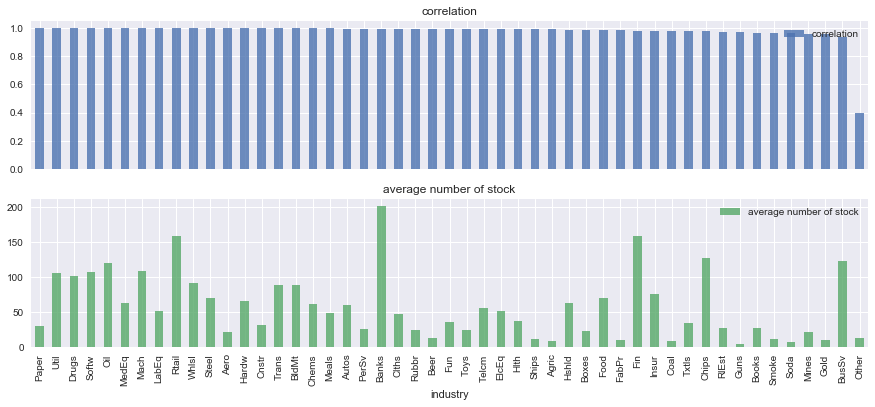

In [14]:
correlation = []
for i in range(49):
    corr = ff49_ret_ew_1.iloc[:,i].to_frame('ret').join(ff49_ew_ref.iloc[:,i].to_frame('ff49')).corr().iloc[0,1]
    col_name = ff49_ret_ew_1.columns[i]
    correlation.append((col_name,corr))

correlation = pd.DataFrame(correlation,columns=['industry','correlation']).sort_values('correlation',ascending=False)
correlation.index = correlation['industry']
del correlation['industry']
ind_n_stock_daily = ret_1.groupby(['date','ff49'])['ret'].count().to_frame('n').unstack()
ind_n_stock_daily = ind_n_stock_daily.replace(np.nan,0)
ind_n_stock_daily_avg = ind_n_stock_daily.mean().to_frame('average number of stock')
ind_n_stock_daily_avg = ind_n_stock_daily_avg.reset_index(level=0,drop=True)
correlation_1 = correlation.join(ind_n_stock_daily_avg)
correlation_1.plot(figsize=(15,6), kind='bar', subplots=True, alpha=0.8, grid=True)
plt.show()

### Compute difference with original FF49 daily return and plot the distribution of difference

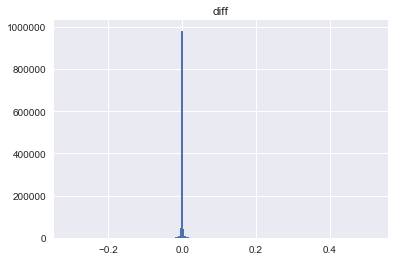

In [15]:
diff_ew = ff49_ret_ew_1 - ff49_ew_ref
diff_ew_ts = diff_ew.mean(1).to_frame('diff')
diff_ew_trans = diff_ew.unstack().to_frame('diff')
diff_ew_trans.hist(bins=200)
plt.show()

### Plot time series difference for each industry

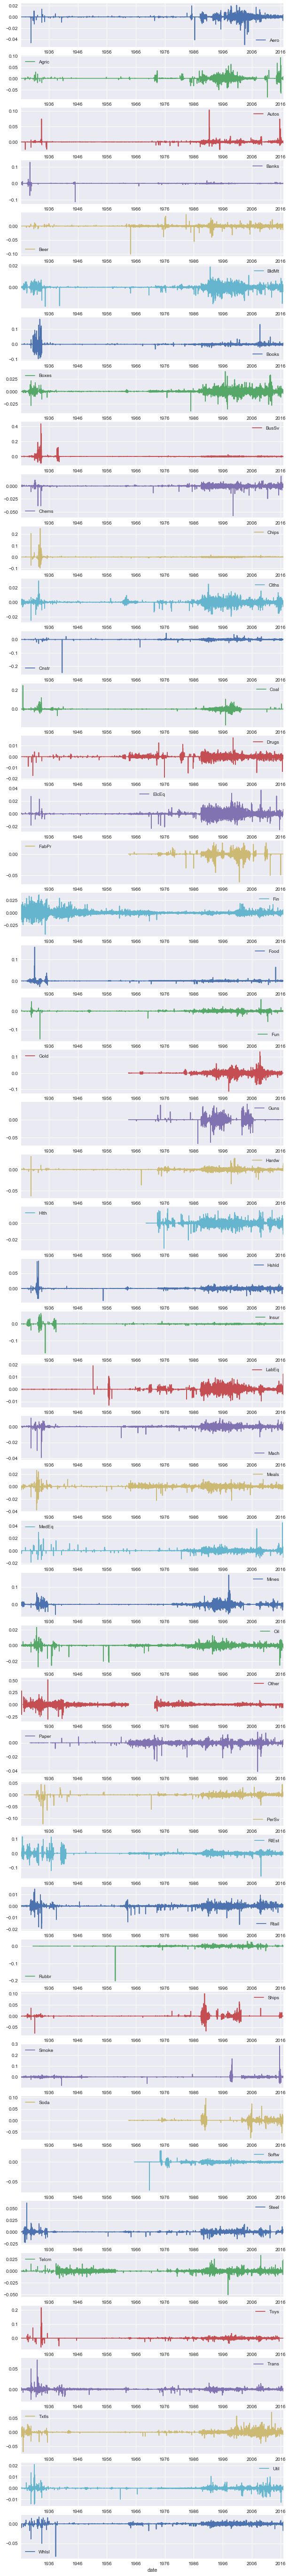

In [16]:
ind_diff = diff_ew.copy()
ind_diff.index = pd.to_datetime(ind_diff.index, format='%Y%m%d')
ind_diff.plot(figsize=(10,100),subplots=True,sharex=False)
plt.show()

### Check difference of firm number in each industry

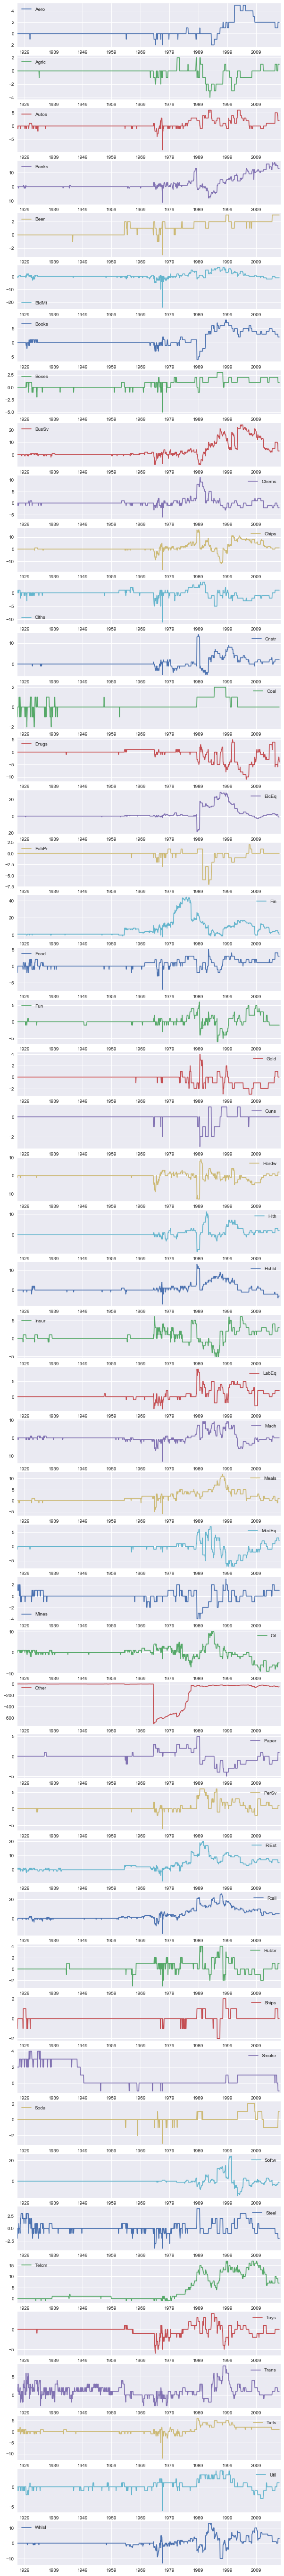

In [17]:
ind_n_stock_month = ind_n_stock_daily.copy()
ind_n_stock_month['yrm'] = (ind_n_stock_month.index/100).astype('int')
ind_n_stock_month = ind_n_stock_month.groupby('yrm').tail(1)
ind_n_stock_month.index = ind_n_stock_month['yrm']
del ind_n_stock_month['yrm']
ind_n_stock_month.columns = ind_n_stock_month.columns.droplevel(0)
del ind_n_stock_month.columns.name
ind_n_stock_month_ff49 = pd.read_csv(data_dir+'ff49_month_num.csv',index_col='date')
ind_n_stock_month_ff49 = ind_n_stock_month_ff49[sorted(list(ind_n_stock_month_ff49.columns))]
ind_n_stock_month_ff49.columns = ind_n_stock_month.columns
ind_n_stock_month_diff = ind_n_stock_month - ind_n_stock_month_ff49
ind_n_stock_month_diff.index = pd.to_datetime(ind_n_stock_month_diff.index,format='%Y%m')
ind_n_stock_month_diff.plot(figsize=(10,100),sharex=False,subplots=True)
plt.show()